In [8]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

1. Lage en tom testmappe i data mappen.
2. Legge til MURAv1.1 med train og valid mappene i data mappen.(kan slette de csv filene som følger med i MURA-v1.1) 
3. Kjøre scriptet "renaming_and_move_test_files"
4. Kjøre notebooken (edited)

# MURA

In [9]:
import sys
import os.path
sys.path.append("../../fastai/")

In [15]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
from sklearn.metrics import confusion_matrix

In [16]:
# See how many devices are around
#torch.cuda.device_count()
# Set it to a particular device
#torch.cuda.set_device(1)
# Check which device you are on
#torch.cuda.current_device()

In [19]:
NB_DIR = %pwd
PATH = f'{NB_DIR}/data/'

In [22]:
cleaned_label_path = f'{PATH}cleaned_label.csv'

In [23]:
os.path.isfile(cleaned_label_path) #hvis den er laget kan man skippe til load cleaned label

True

 # Hopp til load cleanled label hvis filen finnes fra før av

In [37]:
df_train_image_paths = pd.read_csv(f'{PATH}train_image_paths.csv',header=None)
df_train_labeled_studies = pd.read_csv(f'{PATH}train_labeled_studies.csv', header=None)

In [11]:
df_train_image_paths.columns = ['Image Index']

In [12]:
df_train_labeled_studies.columns = ['Image Index', 'Abnormality']

In [13]:
#finne indeksen 
df_train_image_paths['Abnormality'] = np.nan

In [14]:
total = 0; 
for index, row in df_train_labeled_studies.iterrows():
    studie_name = row['Image Index']
    studie_abnormality = row['Abnormality']
    
    df = df_train_image_paths['Image Index'].str.contains(studie_name)
    df = df[df]
    idx_list = list(df.index)
    df_train_image_paths.loc[idx_list, 'Abnormality'] = studie_abnormality      
    total = total + len(idx_list);

In [15]:
df_train_image_paths.shape, total

((36808, 2), 36808)

In [16]:
df_train_image_paths.head()

,Image Index,Abnormality
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,1.0
1,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,1.0
2,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,1.0
3,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,1.0
4,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,1.0


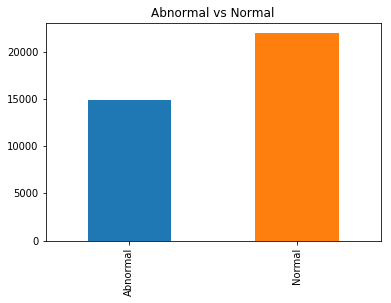

In [23]:
df_sorted = df_train_image_paths.pivot_table(index='Abnormality', aggfunc=len).sort_values('Image Index') 
df_sorted.index = ['Abnormal','Normal']
df_sorted['Image Index'].plot(kind='bar', title="Abnormal vs Normal")

In [18]:
df_train_image_paths.to_csv(cleaned_label_path, index=False)

In [20]:
df_sorted.index

Float64Index([1.0, 0.0], dtype='float64', name='Abnormality')

# Load cleaned label

In [7]:
df_train_image_paths = pd.read_csv(cleaned_label_path)

NameError: name 'cleaned_label_path' is not defined

In [55]:
n = len(df_train_image_paths)-1
val_idxs = get_cv_idxs(n, val_pct=0.15) 

In [56]:
len(val_idxs)

0

In [57]:
df_train_image_paths.shape

(36808, 2)

# View data

In [98]:
sz = 64
arch = dn121
bs = 16

In [99]:
#aug_tfms = [RandomLighting(b=0, c=8), RandomFlip()]
def get_data(sz): 
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
  #transforms_side_on
    return ImageClassifierData.from_csv(PATH ,'', cleaned_label_path , tfms=tfms, bs=bs, val_idxs = 0);

In [100]:
data = get_data(sz)

In [101]:
fn = PATH+data.trn_ds.fnames[10]

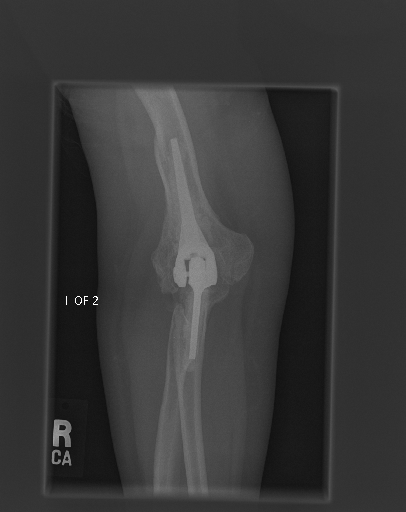

In [102]:
img = PIL.Image.open(fn);
img

In [65]:
data.trn_ds.fnames.shape ,data.val_ds.fnames.shape

((36807,), (1,))

# Training

In [66]:
learn = ConvLearner.pretrained(arch, data, ps = 0.4, opt_fn=optim.Adam) 

 66%|██████▋   | 1530/2301 [07:10<03:37,  3.55it/s, loss=2.68] 

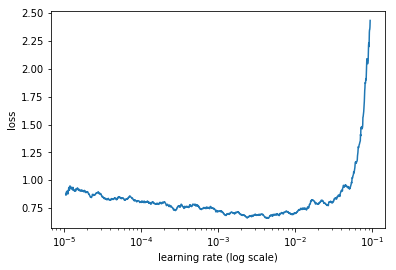

 66%|██████▋   | 1530/2301 [07:30<03:46,  3.40it/s, loss=2.68]

In [67]:
learn.lr_find()
learn.sched.plot()

In [69]:
lr = 0.0001

In [70]:
learn.fit(lr,2, cycle_len=1, cycle_mult=2) 

  4%|▍         | 89/2301 [00:06<02:44, 13.42it/s, loss=0.916]

Exception in thread Thread-5:
Traceback (most recent call last):
  File "/home/sathiesh/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/sathiesh/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_monitor.py", line 62, in run
    for instance in self.tqdm_cls._instances:
  File "/home/sathiesh/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                      
    0      0.667799   0.247174   1.0       
    1      0.635512   0.313962   1.0                           
    2      0.602751   0.327407   1.0                           



[array([0.32741]), 1.0]

In [71]:
lrs = [lr/9, lr/3, lr] #TODO uten TL bør jeg dele på 9 og 3
learn.unfreeze()

In [ ]:
learn.fit(lrs, 2, cycle_len=1, cycle_mult=2)
learn.save(f'{sz}dn121trening')

epoch      trn_loss   val_loss   accuracy                      
    0      0.596805   0.240041   1.0       
 96%|█████████▌| 2203/2301 [02:22<00:06, 15.47it/s, loss=0.557]

In [ ]:
sz = 128

In [ ]:
learn.set_data(get_data(sz))
learn.freeze()

In [ ]:
learn.fit(lr, 2, cycle_len=1, cycle_mult=2)

In [ ]:
learn.unfreeze();
learn.fit(lrs, 2, cycle_len=1, cycle_mult=2)

In [ ]:
learn.save(f'{sz}dn121trening')

In [ ]:
sz = 299

In [ ]:
learn.set_data(get_data(sz))
learn.freeze() 

In [ ]:
learn.fit(lr, 2, cycle_len=1, cycle_mult=2)

In [ ]:
learn.unfreeze()
learn.fit(lrs, 2, cycle_len=1, cycle_mult=2)
learn.save(f'{sz}trening1')

In [ ]:
learn.fit(lrs, 2, cycle_len=1, cycle_mult=2)
learn.save(f'{sz}trening2')

In [ ]:
learn.fit(lrs, 2, cycle_len=1, cycle_mult=2)
learn.save(f'{sz}trening3')

# Prediction on test set

In [137]:
sz = 299
data = get_data(sz)
learn = ConvLearner.pretrained(arch, data, ps = 0.4, opt_fn=optim.Adam) 
learn.load("299trening3")

In [138]:
df_test = pd.read_csv(cleaned_label_path)
df_test.head()

,Image Index,Abnormality
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,1.0
1,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,1.0
2,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,1.0
3,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,1.0
4,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,1.0


### Predict studies 

In [139]:
trn_tfms, val_tfms = tfms_from_model(arch, sz) # get transformations
def predict_abnormality(fn): 
    im = open_image(fn)
    im_val = val_tfms(im)
    preds = learn.predict_array(im_val[None])
    return np.argmax(preds)

In [ ]:
#value inneholder alle indeksene til et studie 
arr = []; 
for index, row in df_test.iterrows():     
    prediction = predict_abnormality(PATH+row['Image Index'])
    if (row['Abnormality'] == 1 and prediction != 1):
        arr.append(row['Image Index'])

In [ ]:
len(arr) #tidligere 3544 m treningaug3, #3373 m trening2

In [ ]:
import numpy as np

In [ ]:
x = np.array(df_test['Abnormality'].values, dtype=bool)

In [ ]:
df_test[x].size

In [ ]:
file = open('remove_images.txt', 'w')
for item in arr:
  file.write("%s\n" % item)
file.close()

In [30]:
f = open('remove_images.txt', 'r')
arr = f.read().splitlines()
f.close()

FileNotFoundError: [Errno 2] No such file or directory: 'MURA-v1.1/train/XR_SHOULDER/patient00003/study1_positive/image1.png'

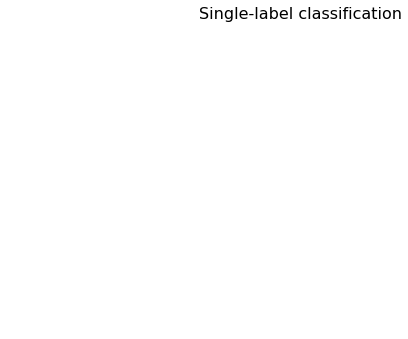

In [36]:
plots_from_files(arr[0:5], maintitle="Single-label classification")